In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torchvision.utils import make_grid

In [2]:

# transformation to the image dataseet:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a fixed size
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()           # Convert images to PyTorch tensors and scale to [0, 1]
])

In [3]:
train_dir = "Alzheimer_s Dataset/train"

In [4]:
test_dir = "Alzheimer_s Dataset/test"

In [5]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

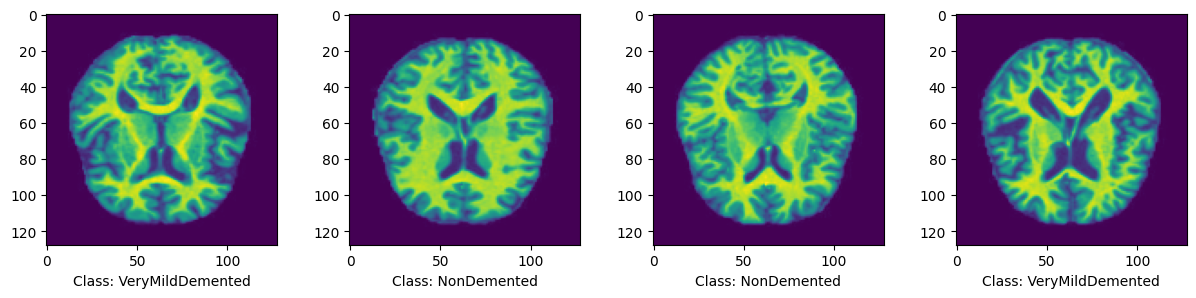

In [7]:
images, labels = next(iter(train_loader))

# Number of images you want to display
num_images = 4

# Create a grid for the images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

class_names = train_dataset.classes

for i in range(num_images):
    # Convert image tensor to numpy array and transpose the axes
    # PyTorch tensors are in (C, H, W) format, and Matplotlib expects (H, W, C)
    img = images[i].numpy().transpose(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis('on')  # Turn off axis
    axes[i].set_xlabel(f'Class: {class_names[labels[i].item()]}') # Set the label as x-axis label

plt.show()

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


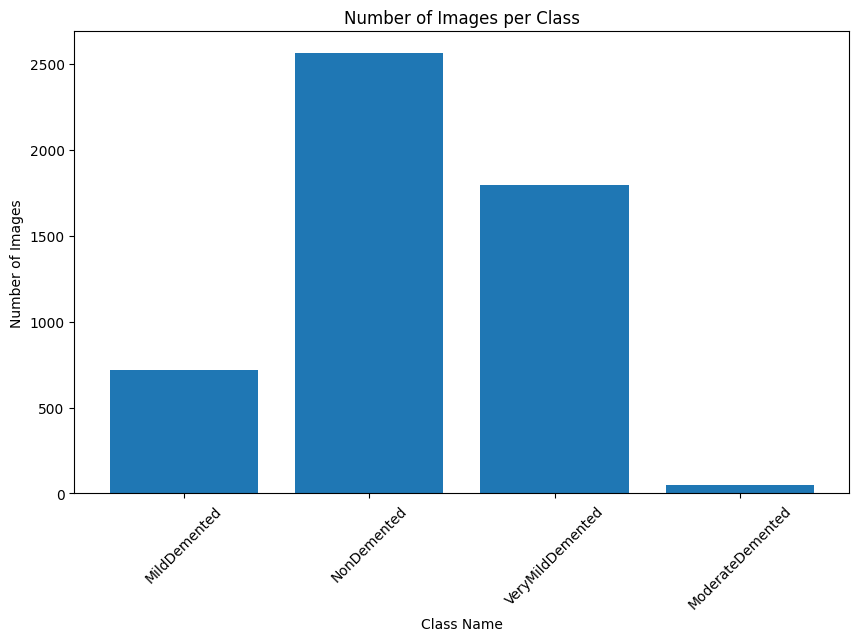

In [8]:
class_names = train_dataset.classes
print(class_names)

# Initialize a Counter to hold the count of each class
class_counts = Counter()
# Iterate over the DataLoader to count labels
for _, labels in train_loader:
    class_counts.update(labels.tolist())

# Convert the counts to lists for plotting
class_indices, counts = zip(*class_counts.items())
class_labels = [class_names[i] for i in class_indices]

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(class_labels, counts, align='center')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)  # Rotate class names for better readability
plt.title('Number of Images per Class')
plt.show()

In [9]:
class_counts = Counter([label for _, label in train_dataset])

# Print the class name and the number of images in each class
for class_index, count in class_counts.items():
    print(f"{train_dataset.classes[class_index]}: {count}")


MildDemented: 717
ModerateDemented: 52
NonDemented: 2560
VeryMildDemented: 1792


In [10]:
def calculate_flattened_output(input_size, input_channels,
                               conv1_filter_size, conv1_filters, conv1_stride,
                               conv2_filter_size, conv2_filters, conv2_stride,
                               pool_size, pool_stride):
    # Function to calculate output size of conv layer
    def conv_output_size(size, filter_size, stride):
        return (size - filter_size) // stride + 1

    # Function to calculate output size of pool layer
    def pool_output_size(size, pool_size, pool_stride):
        return (size - pool_size) // pool_stride + 1

    # Calculate output size after each layer
    conv1_output = conv_output_size(input_size, conv1_filter_size, conv1_stride)
    pool1_output = pool_output_size(conv1_output, pool_size, pool_stride)

    conv2_output = conv_output_size(pool1_output, conv2_filter_size, conv2_stride)
    pool2_output = pool_output_size(conv2_output, pool_size, pool_stride)

    # Calculate flattened output size
    flattened_output = pool2_output * pool2_output * conv2_filters
    return flattened_output

# Example call
output_size = calculate_flattened_output(128, 1, 3, 16, 1, 3, 32, 1, 2, 2)
print(output_size)

28800


In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 30 * 30, 64)  # Adjusted size
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 4)  # Assuming 4 classes

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 30 * 30)  # Adjusted size
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
# Split the dataset into training and validation sets (80-20 split)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data= torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [13]:
batch_size = 4
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [14]:
# Initialize the model
model = SimpleCNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28800, out_features=64, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

In [18]:
import torch.nn.functional as F

best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement before stopping
patience_counter = 0
train_losses = []
val_losses = []
val_accuracies = []
all_preds = []
all_labels = []
num_epochs=10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = val_corrects.double() / len(val_loader.dataset)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset counter
        # Optionally save the model
        torch.save(model,'CNN_98_acc.pt')
    else:
        patience_counter += 1

    # Early stopping check
    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

Epoch 1/10, Train Loss: 0.2090, Val Loss: 0.1995, Val Accuracy: 0.935609756097561
Epoch 2/10, Train Loss: 0.0781, Val Loss: 0.2694, Val Accuracy: 0.904390243902439
Epoch 3/10, Train Loss: 0.0651, Val Loss: 0.1771, Val Accuracy: 0.9307317073170732
Epoch 4/10, Train Loss: 0.0328, Val Loss: 0.1294, Val Accuracy: 0.9512195121951219
Epoch 5/10, Train Loss: 0.0330, Val Loss: 0.0637, Val Accuracy: 0.9804878048780488
Epoch 6/10, Train Loss: 0.0136, Val Loss: 0.0787, Val Accuracy: 0.9795121951219512
Epoch 7/10, Train Loss: 0.0327, Val Loss: 0.0590, Val Accuracy: 0.9834146341463414
Epoch 8/10, Train Loss: 0.0156, Val Loss: 0.1224, Val Accuracy: 0.9570731707317073
Epoch 9/10, Train Loss: 0.0065, Val Loss: 0.1146, Val Accuracy: 0.968780487804878
Epoch 10/10, Train Loss: 0.0409, Val Loss: 0.1090, Val Accuracy: 0.9736585365853658


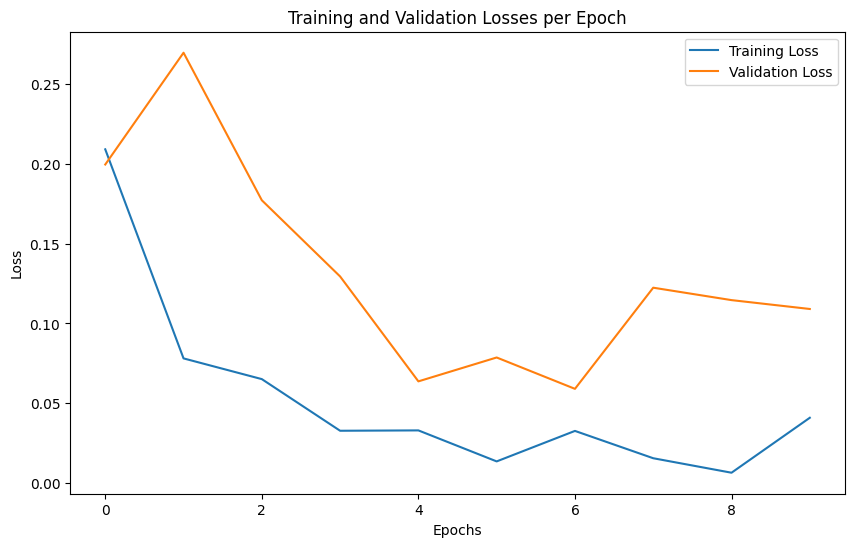

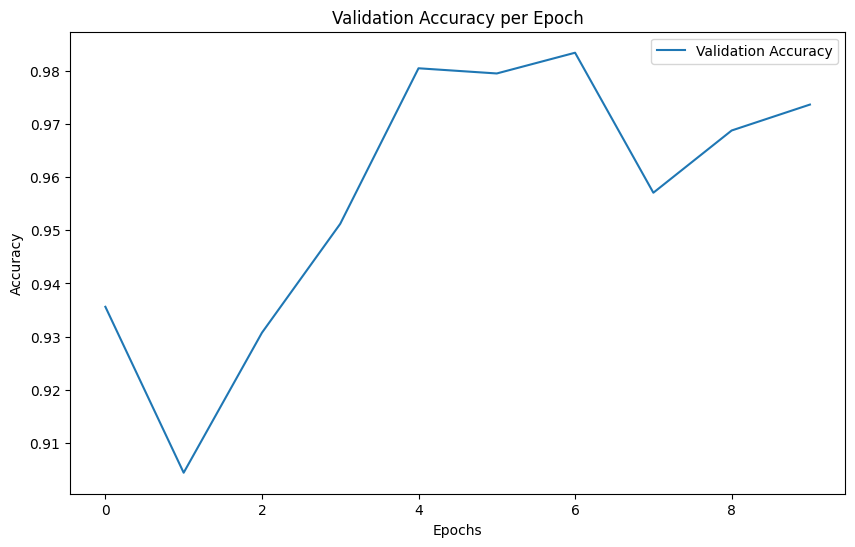

In [19]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training and Validation Losses per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

val_acc=[]
for val in val_accuracies:
    val_acc.append(val.cpu().numpy())

plt.figure(figsize=(10, 6))
plt.plot(val_acc, label='Validation Accuracy')
plt.title("Validation Accuracy per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

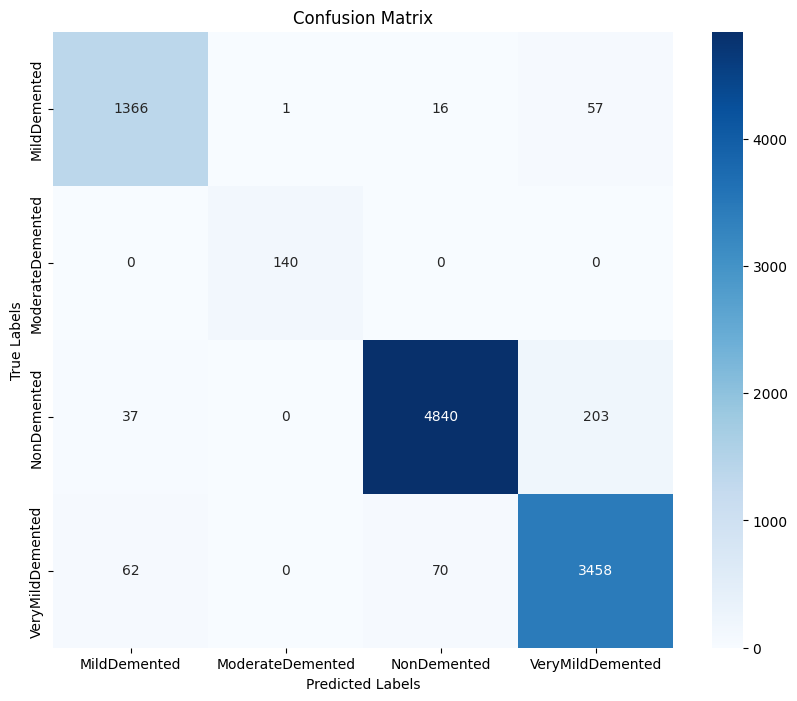

In [20]:
# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()